# Lab 7: LLM API server and Web interfaces

In this lecture, you will learn how to serve modern large models on Linux servers with easy-to-use user interface. We will be using Python as our main programming language, and we do not require knowledge about front-end language such as Javascript or CSS.

## 1 Calling Web Service APIs

In this experiment, we'll equip you with the basic knowledge and practical skills to start making powerful HTTP requests in Python. We'll cover GET and POST methods, and explore JSON data exchange. So, buckle up, let's code!

First, we will need `requests` library. Install it with the following command.

In [2]:
%pip install requests

Looking in indexes: https://mirrors.aliyun.com/pypi/simple/
Note: you may need to restart the kernel to use updated packages.


We can see that the sent data is actually received by the server (`form` shows the exactly the same data we sent).

This is just the tip of the iceberg! Now you have seen how we can utilize the existing web service. In the remaining experiments, you will be building your own API server and web service with a nice user interface.

## 2 Creating an API server using FastAPI

Most of you should have experienced the LLM APIs we provided, which allows your program accessing the power of large language models. Here we will guide you to build your own LLM service, using the `fastapi` library of Python.

`fastapi` takes care of the job of launching a web server and serve the API calls. You only need to define a function that takes the input data from the request to produce output. `fastapi` will handle the rest things for you.

First, install the dependency of `fastapi`.

### 2.1 Basics on FastAPI

In [6]:
%pip install uvicorn fastapi websockets

Looking in indexes: https://mirrors.aliyun.com/pypi/simple/
Note: you may need to restart the kernel to use updated packages.


### 2.2 Creating an API to serve local LLM model

First, let's recall how you run a local LLM.  The following scripts starts a Phi-3 model.

In [26]:
%%file /tmp/llm_api.py

import os
from transformers import AutoModelForCausalLM, AutoTokenizer, pipeline
         
from fastapi import FastAPI, Request
from pydantic import BaseModel
import uvicorn

from urllib.parse import unquote

app = FastAPI()

def chat_resp(model, tokenizer, user_prompt=None, history=[]):
    pipe = pipeline(
        "text-generation",
        model=model,
        tokenizer=tokenizer,
    )   
    generation_args = {
        "max_new_tokens": 500,
        "return_full_text": False,
        "temperature": 0.6,
        "do_sample": True,
    }
    if not history:
        messages = [{"role": "system", "content": "You are a helpful assistant."},]
    else:
        messages = history
    if user_prompt:
        prompt_msg = [{"role": "user", "content": user_prompt}]
        messages.extend(prompt_msg)
    output = pipe(messages, **generation_args)
    return output

#### Your Task ####
## Implement a GET handler that takes in a single string as prompt from user,
## and return the response as a single string.
@app.get("/run/")
async def get_response(q: str):
    user_prompt = unquote(q)  # Decode URL-encoded string
    response = chat_resp(model, tokenizer, user_prompt=user_prompt)
    return {"response": response}
#### End Task ####

#### Your Task ####
## Implement a POST handler that takes in a single string and a history
class ChatRequest(BaseModel):
    query: str
    history: list

@app.post("/run/")
async def post_response(encoded: ChatRequest):
    user_prompt = unquote(encoded.query)
## and return the response as a single string.
    response = chat_resp(model, tokenizer, user_prompt=user_prompt, history=encoded.history)
    return {"response": response}

#### End Task ####

#### Your Task ####
## The main function is the entry point of the script, you should load the model
if __name__ == "__main__":
    model_path = '/ssdshare/Phi-3-mini-128k-instruct/'
    tokenizer = AutoTokenizer.from_pretrained(model_path)
    model = AutoModelForCausalLM.from_pretrained(model_path, 
                                             device_map="cuda:0", 
                                             torch_dtype="auto", 
                                             trust_remote_code=True)
## and then start the FastAPI server.
    uvicorn.run(app, host="0.0.0.0", port=54223)
#### End Task ####


Overwriting /tmp/llm_api.py


In [109]:
## run the following command in your terminal to start the server
## python /tmp/local_llm.py

In [28]:
#### Your Task ####
## Run a LLM single line query with POST 
# and add chat history (history stored on the client side only)
query = "那里有什么好玩的地方吗？"
history = [{"role":"user", "content":"中国的首都是哪里？"}]
data = {"query": query, "history": history}

encoded = json.dumps(data).encode("utf-8")
# Construct the complete URL
post_url = "http://localhost:54223/run"
response = requests.post(post_url, data=encoded)
print(f"Status code: {response.status_code}")
print(response.content.decode(response.encoding))

Status code: 200
{"response":[{"generated_text":" 中国的首都是北京。在北京，游客可以参观故宫，观赏长城的一部分，欣赏天安门广场的历史悠久景象，探索长城脚下的许多秘密遗迹，感受国家博物馆的文化丰富，亲自品尝北京烤鸭和各种传统美食。"}]}


## 3 Adding a Web User Interface using `gradio`

Demo a machine learning application is important. It gives the users a direct experience of your algorithm in an interactive manner. Here we'll be building an interesting demo using `gradio`, a popular Python library for ML demos. Let's install this library.

### 3.1 Basic Gradio

In [17]:
pip install gradio --upgrade

Looking in indexes: https://mirrors.aliyun.com/pypi/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 8.7 MB/s eta 0:00:0000:0100:01m
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 857.8/857.8 kB 14.3 MB/s eta 0:00:00a 0:00:01
  Using cached ffmpy-0.3.2-py3-none-any.whl
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 315.9/315.9 kB 17.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.8/8.8 MB 11.8 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.2/47.2 kB 12.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 20.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.3/88.3 kB 15.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 240.7/240.7 kB 22.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 9.1 MB/s eta 0:00:00:00:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.5/87.5 kB 22.2 MB/s eta 0:00:00
  Attempting uninstall: websockets
    Found existi

Then we are able to write an example UI that takes in a text string and output a processed string. 

### 3.4 A better way to build a web UI for LLM (through an LLM API server)

Next, you should implement a script that interact with the Phi-3 Chat API server you just created.  

Note that you should directly call the API server using request, instead of running the LLM within your UI server process. 

![Illustration of request](./assets/request.jpg)

In [57]:
%%file /tmp/llm_api.py

import os
from transformers import AutoModelForCausalLM, AutoTokenizer, pipeline
         
from fastapi import FastAPI, Request
from pydantic import BaseModel
import uvicorn

import json
from urllib.parse import unquote

app = FastAPI()

def chat_resp(model, tokenizer, user_prompt=None, history=[]):
    pipe = pipeline(
        "text-generation",
        model=model,
        tokenizer=tokenizer,
    )   
    generation_args = {
        "max_new_tokens": 500,
        "return_full_text": False,
        "temperature": 0.6,
        "do_sample": True,
    }
    if not history:
        messages = [{"role": "system", "content": "You are a helpful assistant."},]
    else:
        messages = history
    if user_prompt:
        prompt_msg = [{"role": "user", "content": user_prompt}]
        messages.extend(prompt_msg)
    output = pipe(messages, **generation_args)
    return output

class ChatRequest(BaseModel):
    query: str
    history: list

@app.post("/chat")
async def post_response(encoded: ChatRequest):
    response = chat_resp(model, tokenizer, user_prompt=encoded.query, history=encoded.history)
    return {"response": response}
## and return the response as a single string.

#### End Task ####

#### Your Task ####
## The main function is the entry point of the script, you should load the model
if __name__ == "__main__":
    model_path = '/ssdshare/Phi-3-mini-128k-instruct/'
    tokenizer = AutoTokenizer.from_pretrained(model_path)
    model = AutoModelForCausalLM.from_pretrained(model_path, 
                                             device_map="cuda:0", 
                                             torch_dtype="auto", 
                                             trust_remote_code=True)
## and then start the FastAPI server.
    uvicorn.run(app, host="0.0.0.0", port=54223)
#### End Task ####


Overwriting /tmp/llm_api.py


In [60]:
%%file /tmp/chatUI.py

import gradio as gr
import requests
import json

API_SERVER_URL = "http://localhost:54223/chat" # Don't forget to start your local API server

def predict(message, history):
#### Your Task ####
# Insert code here to perform the inference
    data = {"query": message, "history": history}
    encoded = json.dumps(data).encode("utf-8")
    response = requests.post(API_SERVER_URL, data=encoded)
    return response.content.decode(response.encoding)
#### End Task ####

gr.ChatInterface(predict).launch()


Overwriting /tmp/chatUI.py


In [ ]:
## Do not forget to start your API server (from above, with the /chat API.)


In [ ]:
## Add the port forwarding (port 7860 by default), and you can see http://localhost:7860 in your browser
## If you do not kill the previous one, the port number will change to 7861 or 7862 automatically. 

You you can also test it programmatically using gradio-client. 

In [28]:
pip install gradio-client

Looking in indexes: https://mirrors.aliyun.com/pypi/simple/
Note: you may need to restart the kernel to use updated packages.


### 3.5 More Gradio: create an UI to serve an image model you created in lab 5.

You can either use the from_pipeline() or create your own, more advanced UI.  In either way, you will need to allow API access to your service (will be needed for the following labs). 

If you feel more adventurous, try a new multi-media model, such as text-to-speach or voice recognition.  We have downloaded some for you at:
/share/model/speecht5_hifigan/,/share/model/speecht5_tts/, and /share/model/whisper-medium/




In [27]:
### 3.5 More Gradio: create an UI to serve an image model you created in lab 5.

#You can either use the from_pipeline() or create your own, more advanced UI.  In either way, you will need to allow API access to your service (will be needed for the following labs). 

%%file /tmp/llm_api.py

## Your Task
## follow the instructions above
from fastapi import FastAPI, Request
import uvicorn
from diffusers import StableDiffusionPipeline
import torch
import base64
from PIL import Image
import io
from fastapi.responses import JSONResponse
from pydantic import BaseModel
# import os


app = FastAPI()
import logging
logging.basicConfig(level=logging.DEBUG, filename='app.log', filemode='a', format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

class ChatRequest(BaseModel):
    prompt: str

@app.post("/generate_image")
async def post_response(query: ChatRequest):
    logger.debug("Root endpoint accessed") #Doesn't reach this point
    pipeline = StableDiffusionPipeline.from_pretrained(model_path, torch_dtype=torch.float16, variant="fp16").to("cuda")
    output = pipeline(query.prompt)
    image = output.images[0]
    buffered = io.BytesIO()
    image.save(buffered, format="JPEG")
    img_str = base64.b64encode(buffered.getvalue()).decode()
    return JSONResponse(content={"image": img_str})

if __name__ == "__main__":
    model_path = "/share/lab5/sd"
## and then start the FastAPI server.
    uvicorn.run(app, host="0.0.0.0", port=54223)


Overwriting /tmp/llm_api.py


In [30]:

%%file /tmp/chatUI.py

import gradio as gr
import requests
import json
import io
from PIL import Image
import base64

##Gradio UI
API_SERVER_URL = "http://localhost:54223/generate_image" # Don't forget to start your local API server

import logging
logging.basicConfig(level=logging.DEBUG, filename='app.log', filemode='a', format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

def predict(text_input):
    ## Your Task
    # Insert code here to perform the inference
    data = {"prompt": text_input}
    query = json.dumps(data).encode("utf-8")
    response = requests.post(API_SERVER_URL, data=query)
    logger.debug(response.json())
    img_str = response.json()["image"]
    image = Image.open(io.BytesIO(base64.b64decode(img_str)))
    return image

gr.Interface(fn=predict, inputs="text", outputs="image").launch(show_error=True)


Overwriting /tmp/chatUI.py


In [42]:
from gradio_client import Client
import base64
import requests
from PIL import Image
from io import BytesIO
##Test
client = Client("http://127.0.0.1:7860/")
result = client.predict(
		text_input="young Hungarian girl in front of meadow, frontlight, centered composition, close-up, bright, masterpiece, 3D rendering, 8k",
		api_name="/predict"
)


Loaded as API: http://127.0.0.1:7860/ ✔
/tmp/gradio/3d8850cc9b3362380c0021fcf0a80e88efed7ef8/image.webp


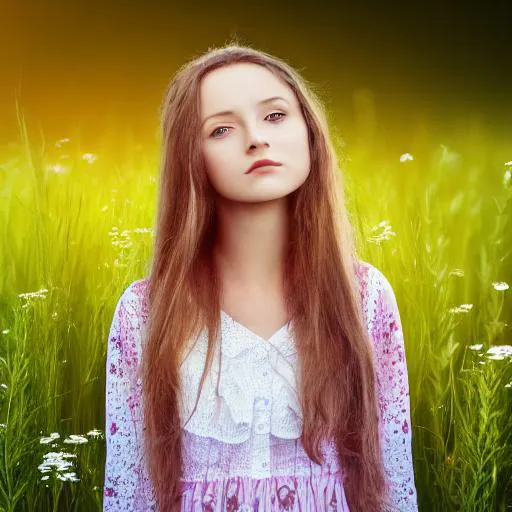

In [44]:
image_path = result
from PIL import Image
# Open the image
image = Image.open(image_path)
# Display the image
image.show()